In [1]:
%%capture
!pip3 install tensorflow==2.0.0-beta1

# Load the TensorBoard notebook extension
# Restart the jupyter notebook if you just installed TF 2.0 Beta
%load_ext tensorboard

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import gym
import datetime
from tqdm import tqdm
import logging
import random

In [3]:
!rm -rf ./logs/

# Go Environment
Train on a small board with heuristic reward for fast training and efficient debugging

In [4]:
%%capture
!pip3 install -e gym-go

In [5]:
go_env = gym.make('gym_go:go-v0', size='S', reward_method='heuristic')

In [6]:
BOARD_SIZE = 7

# Machine Learning Models
Actor-Critic method

In [7]:
from tensorflow.keras import layers

In [8]:
class ActorCritic(tf.keras.Model):
    def __init__(self, mode):
        super().__init__()
        
        assert mode == 'actor' or mode == 'critic'
        
        self.main = tf.keras.Sequential([
            layers.Conv2D(input_shape=(BOARD_SIZE, BOARD_SIZE, 4), bias_initializer="ones", 
                          filters=16, kernel_size=5, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters=64, kernel_size=5, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters=64, kernel_size=5, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters=16, kernel_size=5, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters=1, kernel_size=5, padding="same"),
            layers.Flatten(),
        ])
        
        if mode == 'actor':
            self.main.add(layers.Softmax())
            
        self.main.add(layers.Reshape((BOARD_SIZE, BOARD_SIZE)))
            
        
        self.pass_decision = tf.keras.Sequential([
            layers.Conv2D(input_shape=(BOARD_SIZE, BOARD_SIZE, 4), 
                          filters=16, kernel_size=5, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters=64, kernel_size=5, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters=64, kernel_size=5, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Flatten(),
            layers.Dense(4 * BOARD_SIZE**2),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Dense(BOARD_SIZE**2),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Dense(BOARD_SIZE),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Dense(1, activation="sigmoid" if mode == 'actor' else None),
        ])
    def call(self, inputs):
        action_prob_distr = self.main(inputs)
        pass_decision = self.pass_decision(inputs)
        return action_prob_distr, pass_decision

In [9]:
actor = ActorCritic(mode='actor')

In [10]:
critic = ActorCritic(mode='critic')

In [11]:
import os
if not os.path.exists('tmp'):
    os.mkdir('tmp/')
actor.save_weights('tmp/opp.h5')
opponent = ActorCritic(mode='actor')
opponent.load_weights('tmp/opp.h5')

In [12]:
state = go_env.reset()
state, reward, done, info = go_env.step((3,5))
state, reward, done, info = go_env.step((5,3))

In [13]:
def plot_state(state, channels_last=False):
    plt.figure()
    for i, (layer, name) in enumerate(zip([state[0], state[1], state[2], state[3]] if not channels_last else 
                                          [state[:,:,0], state[:,:,1], state[:,:,2], state[:,:,3]], 
                                          ['black', 'white', 'invalid', 'pass'])):
        plt.subplot(1,4,i+1)
        plt.title(name)
        plt.imshow(layer)
    plt.tight_layout()

Tensorflow expects images to be `channels last`. 

This can be adapted to with `tranpose`.


Ensure the `transpose` function doesn't change anything visually

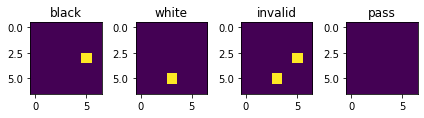

In [14]:
plot_state(state, channels_last=False)

In [15]:
state = state.transpose(1,2,0).reshape(1, BOARD_SIZE, BOARD_SIZE, 4)

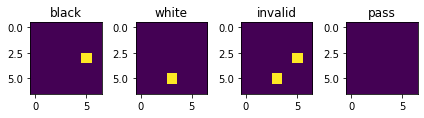

In [16]:
plot_state(state[0], channels_last=True)

### Initialization of models should be random

In [17]:
board_probs, pass_decision = actor(state.astype(np.float32))

In [18]:
board_vals, pass_vals = critic(state.astype(np.float32))

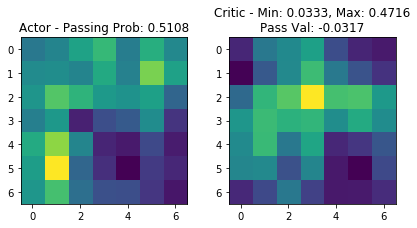

In [19]:
plt.subplot(1,2,1)
plt.title('Actor - Passing Prob: {:.4f}'.format(pass_decision[0][0]))
plt.imshow(board_probs[0])
plt.subplot(1,2,2)
plt.title('Critic - Min: {:.4f}, Max: {:.4f}\nPass Val: {:.4f}'.
          format(tf.math.reduce_min(board_vals[0]), 
                 tf.math.reduce_max(board_vals[0]), 
                 pass_vals[0][0]))
plt.imshow(board_vals[0])
plt.tight_layout()

# Training Setup

### Hyperparameters

In [20]:
NUM_EPISODES = 10
BATCH_SIZE = 64
REPLAY_MEM_SIZE = 1e6
OPPONENT_UPDATE = 10
EPSILON = 1
EPSILON_DECAY = 0.995
EPSILON_MIN = 0.05

In [21]:
from collections import deque

In [22]:
replay_mem = deque(maxlen=int(REPLAY_MEM_SIZE))

### Metrics and Tensorboard

Metrics

In [23]:
actor_loss_metric = tf.keras.metrics.Mean('actor_loss_metric', dtype=tf.float32)
critic_loss_metric = tf.keras.metrics.Mean('critic_loss_metric', dtype=tf.float32)

Tensorboard

In [24]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

### Functions

In [25]:
def random_weighted_action(state, pass_prob, board_weights):
    illegal_mask = state[2]

    masked_prob = np.where(illegal_mask == 0, board_weights, 0)

    # Decide with 1 / BOARD_SIZE ** 2 chance to pass (pass if we have to)
    if np.random.uniform() < pass_prob or np.sum(masked_prob) <= 0:
        action = None
    else:
        # Uniform random chance for all places
        masked_prob /= np.sum(masked_prob)

        action_1d = np.random.choice(np.arange(BOARD_SIZE**2), p=masked_prob.flatten())
        action = (action_1d // BOARD_SIZE, action_1d % BOARD_SIZE)
    return action

In [26]:
def get_action(policy, state, epsilon):
    """
    Gets an action based on exploration/exploitation
    """
    epsilon_choice = np.random.uniform()
    if epsilon_choice < EPSILON:
        # Random move
        logging.debug("Exploring a random move")
        action = random_weighted_action(state, 
                        pass_prob=1/BOARD_SIZE**2, 
                        board_weights=np.ones((BOARD_SIZE, BOARD_SIZE)))
    else:
        # policy makes a move
        logging.debug("Exploiting policy's move")
        act_prob_distr, pass_decision = policy(state
                                               .reshape(1, BOARD_SIZE, BOARD_SIZE, 4)
                                               .astype(np.float32))
        
        action = random_weighted_action(state, pass_prob=pass_decision, 
                                        board_weights=act_prob_distr)
        
    return action

In [27]:
def update_critic():
    """
    Optimizes the critic in one step and updates the critic loss metric
    """
    pass

In [28]:
def update_actor():
    """
    Optimizes the actor in one step and updates the critic loss metric
    """
    
    optimizer = tf.keras.optimizers.Adam()
    
    minibatch = random.sample(replay_mem, BATCH_SIZE)
    minibatch = list(zip(*minibatch))
                
    states = np.array(list(minibatch[0]), dtype=np.float32)
    states = states.transpose(0,3,2,1)
    actions = np.array(list(minibatch[1]))
    
    board_prob_distrs, passing_probs = actor(states)
    board_val_distrs, passing_vals = critic(states)
    
    passing_probs = tf.reshape(passing_probs, (-1,))
    passing_vals = tf.reshape(passing_vals, (-1,))
        
    # state value is the expected critic value based on the actor's policy
    state_vals = board_prob_distrs * board_val_distrs 
    state_vals = passing_probs * passing_vals + (1 - passing_probs) * tf.reduce_sum(state_vals, axis=[1,2])
    
    # Action values
    action_vals = tf.gather_nd(board_val_distrs, [(i, a[0], a[1]) if a is not None 
                                                      else (i,0,0) 
                                                  for i, a in enumerate(actions)])
    action_vals = tf.where([a is not None for a in actions], action_vals, passing_vals)
    
    # Advantage values
    avntg_vals = action_vals - state_vals
    
    with tf.GradientTape() as tape:
        board_prob_distrs, passing_probs = actor(states)
        passing_probs = tf.reshape(passing_probs, (-1,))
        
        action_probs = tf.gather_nd(board_prob_distrs, [(i, a[0], a[1]) if a is not None 
                                                        else (i, 0, 0) 
                                                        for i, a in enumerate(actions)])
        action_probs = tf.where([a is not None for a in actions], action_probs, passing_probs)
        
        loss = - tf.math.log(action_probs + 1e-6) * avntg_vals
        loss = tf.math.reduce_mean(loss)
    
    # log the loss in tensorboard
    actor_loss_metric(loss)
    logging.debug("actor loss: {}".format(loss))
        
    # compute and apply gradients
    gradients = tape.gradient(loss, actor.trainable_variables)
    optimizer.apply_gradients(zip(gradients, actor.trainable_variables))

In [29]:
def train(episode):
    """
    Plays out a game, and iteratively updates the models at each step
    """
    global EPSILON
    
    # Basic setup
    done = False
    num_of_turns = 0
    state = go_env.reset()
    
    while not done:
        # Copy state for memory
        orig_state = np.copy(state)
        
        action = get_action(actor, state, EPSILON)
        if action is None:
            logging.debug("Black (actor) passed")
            
        state, reward, done, info = go_env.step(action)
        num_of_turns += 1
        
        # Add to memory
        replay_mem.append((orig_state, action, state, reward, done))
        
        # Update the models if we have enough events
        if len(replay_mem) >= BATCH_SIZE:
            update_critic()        
            update_actor()
    
            # Update exploration/exploitation
            if EPSILON > EPSILON_MIN:
                EPSILON *= EPSILON_DECAY
                logging.debug("Epsilon decayed to {}".format(EPSILON))
            
        if done:
            break
            
        # opponent makes a move
        # swap the black and white layers
        temp = np.copy(state[0])
        state[0] = state[1]
        state[1] = temp
        # get action from opponent
        action = get_action(opponent, state, epsilon=0)
        if action is None:
            logging.debug("White (opponent) passed")

        state, reward, done, info = go_env.step(action)
        num_of_turns += 1
    
    # Game ended
    return num_of_turns, reward

# Train

In [30]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [31]:
%tensorboard --logdir logs/gradient_tape

Reusing TensorBoard on port 6006 (pid 59977), started 2 days, 1:14:46 ago. (Use '!kill 59977' to kill it.)

In [ ]:
rewards = []

for episode in tqdm(range(NUM_EPISODES)):
    # Reset loss metrics
    actor_loss_metric.reset_states()
    critic_loss_metric.reset_states()
    
    if episode % OPPONENT_UPDATE == 0:
        actor.save_weights('tmp/opp.h5')
        opponent = ActorCritic(mode='actor')
        opponent.load_weights('tmp/opp.h5')
    
    num_turns, reward = train(episode)
    rewards.append(reward)
    
    # log results
    with train_summary_writer.as_default():
        tf.summary.scalar('actor loss', actor_loss_metric.result(), step=episode)
        tf.summary.scalar('critic loss', critic_loss_metric.result(), step=episode)
        tf.summary.scalar('number of moves', num_turns, step=episode)
        tf.summary.histogram('last rewards', rewards, step=episode)

 10%|█         | 1/10 [00:19<02:57, 19.77s/it]

# Evaluate
Play against the actor 💪